# Toxicity Target Classification

In this notebook, we will train a baseline model to predict if a toxic comment is targeted or not.

We will use [simpletransformers](https://simpletransformers.ai/) that is a wrapper for many popular models available in [Hugging Face](https://huggingface.co/).

We will use a pre-trained model ([neuralmind/bert-base-portuguese-cased · Hugging Face](https://huggingface.co/neuralmind/bert-base-portuguese-cased)) that is trained on Portuguese.

## Imports

In the first cell, we set the `KAGGLE_USERNAME` and `KAGGLE_KEY` environment variables. We also import the required packages.

In [1]:
import os

os.environ["KAGGLE_USERNAME"] = None
os.environ["KAGGLE_KEY"] = None

import shutil
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Any
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from simpletransformers.classification import (
    ClassificationModel,
    ClassificationArgs
)

%matplotlib inline

logging.basicConfig(level=logging.INFO)

_logger = logging.getLogger("transformers")
_logger.setLevel(logging.WARNING)

seed = 1993

In the next cell, we will remove some folders used by `simpletransformers`.

In [2]:
temp_folders = ["cache_dir", "outputs", "runs"]

for folder in temp_folders:
    if os.path.exists(folder):
        shutil.rmtree(folder, ignore_errors=True)

## Functions

In this section, we will define some helper functions.

In [3]:
def prep_data(X: List[str], Y: List[int], classes: Dict[Any, int]):
    """
    Prepare data (X, y) in a list.

    Args:
    - X: list of strings (texts)
    - y: List of ints (0 or 1)
    - classes: dictionary of classess ({class_id: class_name, ...})

    Returns:
        List of data.
    """

    def get_key_by_value(dictionary, value):
        "Get key by value in dictionary"
        return next(key for key, val in dictionary.items() if val == value)

    data = []
    for x, y in zip(X, Y):
        y = get_key_by_value(classes, y)
        data.append([x, y])
    return data

## Load the data

In this section, we will download the data and load it into a pandas dataframe.

In [5]:
if not os.path.exists("olidbr.csv"):
    print("Downloading data from Kaggle")
    kaggle = KaggleApi()
    kaggle.authenticate()
    kaggle.dataset_download_file(dataset="olidbr", file_name="olidbr.csv")

df = pd.read_csv("olidbr.csv")

print(f"Shape: {df.shape}")
df.head()

Shape: (711, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,6391e3dbb12848ac8ef6131edf2d69f9,USER Canalha URL,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12]",False,False,True,False,False,False,False,False,False,False,False
1,5a21508c2afc4c3295137451baf8b981,USER VTNSC FDP,OFF,TIN,IND,"[5, 6, 7, 8, 9, 10, 11, 12, 13]",False,False,True,False,False,False,True,False,False,False,False
2,060b0390f99041cd8cd38ca5a2b66907,USER O partido do Kim votou à favor do fundão....,OFF,TIN,IND,NaN,False,False,True,False,False,False,False,False,False,False,False
3,3264fc0b06974c2daf423a9e5998d003,USER Grande homem. Em um país de covardes. Ete...,OFF,TIN,GRP,"[34, 35, 36, 37, 38, 39, 40, 41]",False,False,True,False,False,False,False,False,False,False,False
4,002bced1b7444833bbe5e054c5aa6512,USER USER QAnon Brasil é um bicho estranho. Ob...,OFF,TIN,IND,"[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 3...",False,False,True,False,False,False,True,False,False,False,False


We need to filter out the comments that are not toxic.

In [6]:
df = df[df["is_offensive"] == "OFF"]
df.reset_index(drop=True, inplace=True)

print(f"Shape: {df.shape}")

Shape: (376, 17)


## Explorative analysis

In the second cell, we load the data and perform an exploratory analysis.

In [7]:
df_eda = df[["text", "is_targeted"]].groupby("is_targeted").count()
df_eda.reset_index(inplace=True)
df_eda

,is_targeted,text
0,TIN,304
1,UNT,72


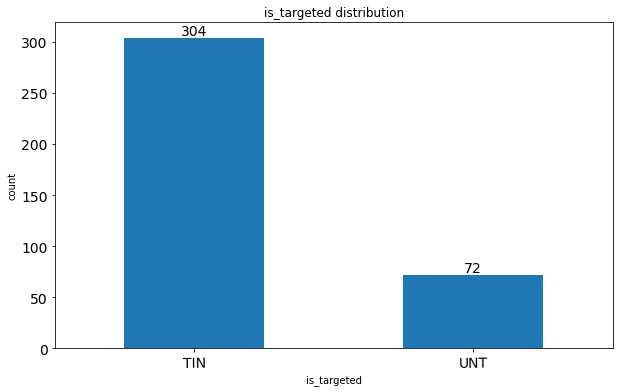

In [9]:
ax = df_eda.plot(x="is_targeted", y="text", kind="bar", legend=False, figsize=(10, 6),
                 xlabel="is_targeted", ylabel="count", fontsize=14,
                 rot=1, title="is_targeted distribution")

for container in ax.containers:
    ax.bar_label(container, fontsize=14)

In [9]:
classes = {
    0: "UNT",
    1: "TIN"
}

## Prepare the data

In this section, we will prepare the data in order to train the model.

The `simpletransformers` library expects the data in a specific format.

More information about the format can be found in the [Classification Data Formats - Simple Transformers](https://simpletransformers.ai/docs/classification-data-formats/#binary-classification)

In [10]:
df = df[["text", "is_targeted"]]

X = df["text"].values
y = df["is_targeted"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=seed,
                                                    stratify=y)
                                                    
train_data = prep_data(X_train, y_train, classes)
test_data = prep_data(X_test, y_test, classes)

df_train = pd.DataFrame(train_data)
df_train.columns = ["text", "labels"]

df_test = pd.DataFrame(test_data)
df_test.columns = ["text", "labels"]

print(f"train_data: {df_train.shape}")
print(f"test_data: {df_test.shape}")

train_data: (263, 2)
test_data: (113, 2)


## Training the model

In this section, we will train a baseline model to predict if a toxic comment is targeted or not.

We will not perform hyperparameter tuning because it is a simple baseline model.

In [11]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)

# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=3)

# Create a ClassificationModel
model = ClassificationModel(
    model_type="bert",
    model_name="neuralmind/bert-base-portuguese-cased",
    args=model_args,
    weight=list(class_weights),
    use_cuda=False
)

# Train the model
model.train_model(df_train)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

(99, 0.21081381087953394)

## Evaluating the model

In this section, we will evaluate the model with the following metrics:

- **Accuracy**: the percentage of correct predictions;
- **Precision**: the percentage of predicted targeted comments that are actually targeted;
- **Recall**: the percentage of targeted comments that are actually predicted as targeted;
- **F1-Score**: the harmonic mean of precision and recall;

In [12]:
result, model_outputs, wrong_predictions = model.eval_model(df_test)

y_true = df_test["labels"].tolist()

y_pred, raw_outputs = model.predict(df_test["text"].tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
  1%|          | 1/113 [00:21<40:00, 21.44s/it]
INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_bert_128_2_2
Running Evaluation: 100%|██████████| 15/15 [00:25<00:00,  1.70s/it]
INFO:simpletransformers.classification.classification_model:{'mcc': 0.3506479275681168, 'tp': 88, 'tn': 6, 'fp': 16, 'fn': 3, 'auroc': 0.8516483516483516, 'auprc': 0.9582638083423994, 'eval_loss': 0.23383268329004447}
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
100%|██████████| 15/15 [00:26<00:00,  1.77s/it]


In [13]:
print(classification_report(y_true, y_pred, digits=4,
                            target_names=classes.values()))

              precision    recall  f1-score   support

         UNT     0.6667    0.2727    0.3871        22
         TIN     0.8462    0.9670    0.9026        91

    accuracy                         0.8319       113
   macro avg     0.7564    0.6199    0.6448       113
weighted avg     0.8112    0.8319    0.8022       113



## Testing the model

In the last section, we will test the model with some comments from the test set.

In [14]:
df_pred = df_test.head(20)

predictions, raw_outputs = model.predict(df_pred["text"].tolist())

df_pred = df_pred.assign(predictions=predictions)

df_pred["labels"] = df_pred["labels"].map(classes)
df_pred["predictions"] = df_pred["predictions"].map(classes)

df_pred

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.
100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


,text,labels,predictions
0,USER Vcs são realmente hipócritas.,TIN,TIN
1,"⌛ HASHTAG | MARÇO: 'Enfia no rabo', diz Eduard...",TIN,TIN
2,"USER VOCê É FODA GAU, MAS ESSA ZIKA SUA É PUTARIA",TIN,TIN
3,A CPI deixou claro como um bando de psicopatas...,TIN,TIN
4,USER Para de defecar pela boca,TIN,TIN
5,USER Te odeio vou fazer campanha contra tuas c...,TIN,TIN
6,USER Uma escolha muito difícil da porra heim E...,TIN,TIN
7,USER Então comece com o redirecionamento dos f...,TIN,TIN
8,USER USER USER Deram cloroquina e ozônio no cu...,TIN,TIN
9,USER Uma calcinha dessa fio-dental dentro da b...,TIN,TIN
